In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_stderr').hide();
 } else {
 $('div.input').show();
 $('div.output_stderr').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action='javascript:code_toggle()'><input STYLE='color: #4286f4' 
type='submit' value='Click here to toggle on/off the raw code.'></form>''')

### Linear methods in classification

1. Load hurricane data from the article "Hurricane-induced selection on the morphology of an island lizard". (You may use ELTE wifi to access materials placed behind Nature's paywall.) https://www.nature.com/articles/s41586-018-0352-3
    - A, Drop the lizard with the most missing values
    - B, Drop the ID column
    - C, Encode, the Sex, Origin ans Hurricane values into binary columns,
    and drop the original text columns.
    - D, Make sure all your columns are encoded as floating point values, 
    not unsigned integers!
----
2. Use logistic regression from the statsmodels package to predict whether
    the lizard was measured after of before the hurricane, 
    using the whole dataset
    - A, Investigate the Toe and Finger area coefficients, whats going on? 
    Fix this problem by only keeping the mean measurements.
    - B, Which measured quality had the most significant positive effect on survival?
    - C, Which measured quality had the most significant negative effect on survival?
    - D, Try explain the results in your words. Check the abstract of the paper.
    - E, Repeat the fit after scaling each input column to 0 mean and 1 variance. 
    Have the coefficients changed? Have the predictions changed?
----
3. Repeat the fit with scikit-learn on the unnormalized dataset.
    - A, Compare the coefficients with the ones you got from statsmodels. 
    Are they the same? If not try to answer why?
    - B, Try to tweak the parameters of the scikit-learn method to reproduce the
    the coefficients produced by statsmodels.
    - C, Plot the ROC curve for the full dataset, and calculate the AUC.
    - D, Repeat the fit after scaling each input column to 0 mean and 1 variance. 
    Have the coefficients changed? Have the predictions changed?
----    
4. Split the dataset into 5 folds and predict each fold by training on the other 4.
    - A, Make sure to fix the seed of the splitting to 0 to make it reproducible.
    - B, Plot the ROC for the 5 folds separately as curves on the same plot.
    - C, Calculate the AUC values for the 5 folds separately.

# <center> Solution 4 Assignment 4 </center>

# 1)

In [237]:
!wget https://datadryad.org/resource/doi:10.5061/dryad.2t41r64

--2019-10-12 12:22:43--  https://datadryad.org/resource/doi:10.5061/dryad.2t41r64
Resolving datadryad.org (datadryad.org)... 52.39.240.87, 54.71.108.87, 54.201.182.94
Connecting to datadryad.org (datadryad.org)|52.39.240.87|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datadryad.org/stash/dataset/doi:10.5061/dryad.2t41r64 [following]
--2019-10-12 12:22:43--  https://datadryad.org/stash/dataset/doi:10.5061/dryad.2t41r64
Reusing existing connection to datadryad.org:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dryad.2t41r64’

dryad.2t41r64           [ <=>                ]  19.25K   102KB/s    in 0.2s    

2019-10-12 12:22:44 (102 KB/s) - ‘dryad.2t41r64’ saved [19707]



In [2]:
import pandas as pd
import numpy as np
import operator
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Donihue 2018-01-00672 Hurricanes Data.csv")

## 1.a)

In [4]:
to_del = sorted({i:j for i,j 
                 in zip(np.linspace(0, df.shape[0], df.shape[0]+1, dtype=int),
                        df.isna().sum(axis=1))}.items(),
                reverse=True, key=operator.itemgetter(1))[0][0]
df.drop(to_del, inplace=True)

## 1.b) & 1.c) 

In [5]:
df= pd.concat([df,pd.get_dummies(df['Origin']),
               pd.get_dummies(df['Sex']),pd.get_dummies(df['Hurricane'])],axis=1)
df['orig'] = df["Water Cay"]
df['sex'] = df["Male"]
df['huric'] = df["After"]
df.drop(["ID","Water Cay", "Pine Cay", "Male", "Female", 
         "Before", "After", "Origin", "Hurricane", "Sex"], axis = 1, inplace = True)

## 1.d)

In [6]:
df = df.astype(float)
df.head()

,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,Radius,Metacarpal,LongestFinger,FingerCount,...,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce,orig,sex,huric
0,48.69,10.39,11.87,7.52,7.43,8.66,7.99,2.22,3.19,10.0,...,2.402,2.369,1.332667,2.433333,2.663,4.791,0.116,0.0,1.0,1.0
1,40.31,8.66,9.79,6.18,6.20,8.01,6.51,2.38,3.55,10.0,...,1.525,1.530,0.961333,1.517667,2.595,3.678,0.048,0.0,0.0,1.0
2,58.30,12.87,14.76,9.45,9.58,11.72,9.54,3.54,5.09,14.0,...,4.140,3.996,2.631333,4.097667,7.347,4.682,0.424,0.0,1.0,1.0
3,43.15,8.55,10.29,6.60,6.26,7.43,6.60,2.79,3.55,11.0,...,1.871,1.867,1.177667,1.878667,2.786,5.378,0.171,0.0,0.0,1.0
4,45.51,10.26,11.02,6.89,7.02,7.71,7.25,2.52,3.37,11.0,...,2.435,2.529,1.384333,2.530333,3.575,6.646,0.014,0.0,0.0,1.0


In [7]:
print(f"An example for a coloumn: {df.SVL.dtype} and the num of distinct values: {df.dtypes.nunique()}")

An example for a coloumn: float64 and the num of distinct values: 1


# 2)

## 2.a) & 2.b) & 2.c)

Taking a look at the specified values:

In [8]:
df[["SumFingers", "SumToes", "MaxFingerForce", "FingerArea1", "FingerArea2", "FingerArea3", "ToeArea1", "ToeArea2", "ToeArea3"]]

,SumFingers,SumToes,MaxFingerForce,FingerArea1,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3
0,2.663,4.791,0.116,1.321,1.338,1.339,2.529,2.402,2.369
1,2.595,3.678,0.048,0.962,0.950,0.972,1.498,1.525,1.530
2,7.347,4.682,0.424,2.507,2.702,2.685,4.157,4.140,3.996
3,2.786,5.378,0.171,1.172,1.175,1.186,1.898,1.871,1.867
4,3.575,6.646,0.014,1.376,1.357,1.420,2.627,2.435,2.529
5,3.829,5.771,0.267,1.428,1.410,1.440,2.061,2.018,2.029
6,5.453,8.427,0.356,1.873,1.850,1.850,2.984,2.983,2.958
7,7.812,9.427,0.191,2.558,2.544,2.574,4.016,3.952,3.968
8,2.680,4.243,0.191,1.114,1.080,1.040,1.794,1.716,1.805
9,6.907,10.913,0.151,2.284,2.344,2.270,3.916,3.913,3.880


The "Sum" coloumns have a lot of missing values. Let us keep only the "Mean" coloumns everywhere, respectively.

In [9]:
df.drop(["SumFingers", "SumToes", "MaxFingerForce", "FingerArea1", "FingerArea2", "FingerArea3", "ToeArea1", "ToeArea2", "ToeArea3"], axis = 1, inplace=True)

In [10]:
m = sm.Logit(df.huric, df.drop("huric", axis = 1))
r = m.fit()
r.summary()

Optimization terminated successfully.
         Current function value: 0.346159
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  huric   No. Observations:                  163
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                           14
Date:                Sat, 12 Oct 2019   Pseudo R-squ.:                  0.4945
Time:                        21:24:07   Log-Likelihood:                -56.424
converged:                       True   LL-Null:                       -111.63
                                        LLR p-value:                 4.669e-17
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
SVL                0.1543      0.186      0.831      0.406      -0.210       0.518
Femur             -2.5930      0.581     -4.463      0.000      -3.732      -1.454
Tibia             -0.6134      0.839     -0.731      0.465      -2.258       1.032
Metatarsal        -0.2347      1.215     -0.193      0.847      -2.616       2.147
LongestToe        -2.7460      0.725     -3.788      0.000      -4.167      -1.325
Humerus            1.7717      0.661      2.681      0.007       0.477       3.067
Radius             0.8794      1.413      0.622      0.534      -1.890       3.648
Metacarpal         0.8842      1.061      0.833      0.405      -1.196       2.965
LongestFinger      0.2915      0.946      0.308      0.758      -1.563       2.146
FingerCount        1.6170      0.429      3.770      0.000       0.776       2.458
ToeCount          -0.0982      0.316     -0.311      0.756      -0.717       0.520
MeanFingerArea     1.9134      1.587      1.206      0.228      -1.197       5.024
MeanToeArea        1.4528      1.209      1.201      0.230      -0.917       3.823
orig              -1.2905      0.612     -2.108      0.035      -2.490      -0.091
sex                0.9492      1.106      0.858      0.391      -1.218       3.117
==================================================================================
"""

In [11]:
print(f"The most impact was: {max(dict(r.params).items(), key = operator.itemgetter(1))}")
print(f"The least impact was: {min(dict(r.params).items(), key = operator.itemgetter(1))}")


The most impact was: ('MeanFingerArea', 1.913411953042594)
The least impact was: ('LongestToe', -2.7460052183032246)


## 2.d)

These results are not in accordance with the results. Maybe the normalization is missing, since every value here is taken in its form which can mess up the calculations i.e. the variations in one coloumn can highly effect the outcome of the result. 

As the abstract says:
>[...] and found that populations of surviving lizards differed in body size, relative limb length and toepad size from those present before the storm. 


## 2.e)

In [12]:
dfn = (df.drop("huric", axis = 1)-df.drop("huric", axis = 1).mean())/df.drop("huric", axis = 1).std()

In [13]:
mn = sm.Logit(df.huric, dfn)
rn = mn.fit()
rn.summary()

Optimization terminated successfully.
         Current function value: 0.273409
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  huric   No. Observations:                  163
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                           14
Date:                Sat, 12 Oct 2019   Pseudo R-squ.:                  0.6008
Time:                        21:24:09   Log-Likelihood:                -44.566
converged:                       True   LL-Null:                       -111.63
                                        LLR p-value:                 1.041e-21
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
SVL               -3.3124      1.635     -2.025      0.043      -6.518      -0.107
Femur             -3.9644      1.107     -3.581      0.000      -6.134      -1.795
Tibia             -2.3871      1.901     -1.255      0.209      -6.114       1.340
Metatarsal         0.6657      1.454      0.458      0.647      -2.185       3.516
LongestToe        -3.7197      0.994     -3.744      0.000      -5.667      -1.772
Humerus            3.1327      1.150      2.723      0.006       0.878       5.387
Radius            -0.8358      1.714     -0.488      0.626      -4.196       2.524
Metacarpal         0.3818      0.464      0.822      0.411      -0.528       1.292
LongestFinger     -0.2578      0.721     -0.358      0.721      -1.670       1.155
FingerCount        1.3951      0.521      2.678      0.007       0.374       2.416
ToeCount          -1.0163      0.562     -1.809      0.070      -2.117       0.085
MeanFingerArea     3.2256      1.201      2.686      0.007       0.872       5.579
MeanToeArea        4.5201      1.524      2.966      0.003       1.533       7.508
orig              -0.8132      0.361     -2.253      0.024      -1.521      -0.106
sex                2.0792      0.720      2.886      0.004       0.667       3.491
==================================================================================
"""

In [14]:
print(f"The most impact was: {max(dict(rn.params).items(), key = operator.itemgetter(1))}")
print(f"The least impact was: {min(dict(rn.params).items(), key = operator.itemgetter(1))}")


The most impact was: ('MeanToeArea', 4.520146184337688)
The least impact was: ('Femur', -3.9643941982593196)


Now it is correct.

# 3)

## 3.a) & 3.b) 

In [15]:
# I honestly did not serach for this, but somehow encountered:
# https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels

As [this link](https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels) says, there is some difference with the regularization and from the previous lectures we know that the Statsmodels does not use a constant automatice. By setting $\texttt{fit_intercept}$ to False and giving a great number ($9e9$) for $\texttt{C}$ parameters.

In [16]:
model = LogisticRegression(fit_intercept=False, C=9e9).fit(df.drop("huric", axis = 1),df.huric )

In [17]:
print("\033[1m" + "The results for the scikit version of Logistic regression and the Statsmodels\':\n" + '\033[0m')
print("\033[1m" + "Coloumn \t\tScikit \t\tStatsmodels" + '\033[0m')

for i,j,k in zip(df.drop("huric", axis = 1).columns,model.coef_[0], r.params):
    print(i,'\t',j,'\t',k)

The results for the scikit version of Logistic regression and the Statsmodels':

Coloumn 		Scikit 		Statsmodels
SVL 	 0.15424910449961238 	 0.15431805374917024
Femur 	 -2.593338522765598 	 -2.5930297727984817
Tibia 	 -0.612389179854254 	 -0.6133663308628365
Metatarsal 	 -0.23336413119859933 	 -0.23467006003731247
LongestToe 	 -2.74613882065705 	 -2.7460052183032246
Humerus 	 1.7732774673267924 	 1.7717096486397745
Radius 	 0.8758945271945359 	 0.8793827317934774
Metacarpal 	 0.8814255688179373 	 0.8842270405126056
LongestFinger 	 0.29109042818741976 	 0.29148399800682795
FingerCount 	 1.6173408655538164 	 1.616969962297927
ToeCount 	 -0.09822428980956163 	 -0.09824217035745192
MeanFingerArea 	 1.9097631632279153 	 1.913411953042594
MeanToeArea 	 1.457347838146414 	 1.4527865201806407
orig 	 -1.2897519529764692 	 -1.2905296769653278
sex 	 0.9458262147019201 	 0.9491871438982359


## 3.c)

In [18]:
w = model.predict(df.drop("huric", axis = 1))

In [19]:
ROC = roc_curve(df.huric, w)
AUC = roc_auc_score(df.huric, w)
print("ROC results\n\n", ROC)

ROC results

 (array([0.        , 0.14084507, 1.        ]), array([0.        , 0.89130435, 1.        ]), array([2., 1., 0.]))


AUC: 0.8752296387017758


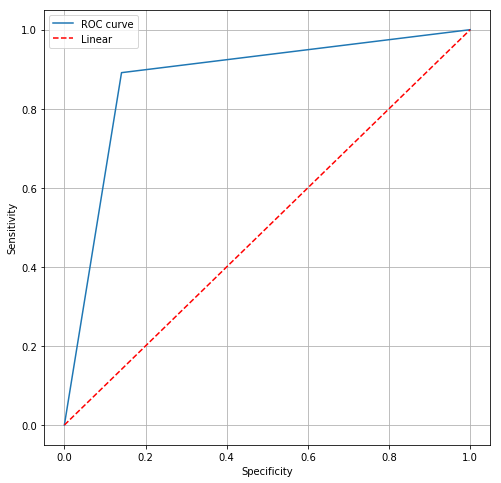

In [20]:
plt.figure(figsize=(8,8))
plt.plot(ROC[0], ROC[1], label = 'ROC curve')
plt.plot([0,1],[0,1], "r--" , label = 'Linear')
plt.grid()
plt.legend(loc = "best")
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
print(f"AUC: {AUC}")

## 3.e) Renorm:

In [21]:
modeln = LogisticRegression(fit_intercept=False, C=9e9).fit(dfn,df.huric )

for i,j,k in zip(df.drop("huric", axis = 1).columns,modeln.coef_[0], rn.params):
    print(i,j,k)

SVL -3.312458136261695 -3.312439542634516
Femur -3.964397492883612 -3.9643941982593196
Tibia -2.3870070614690406 -2.3870914709907343
Metatarsal 0.665642261156165 0.6657389605881696
LongestToe -3.719661353895821 -3.719669330877342
Humerus 3.1326452618273706 3.1326685588229073
Radius -0.835757584623254 -0.8357673157500326
Metacarpal 0.38184625387054616 0.38184642532021984
LongestFinger -0.2578132197672851 -0.25782595593264906
FingerCount 1.3951494587239865 1.3951409059735782
ToeCount -1.0163375905615646 -1.0163339895271208
MeanFingerArea 3.225548174467623 3.225606270456631
MeanToeArea 4.520227821875489 4.520146184337688
orig -0.8131929969811338 -0.813191532542321
sex 2.0791737418900627 2.079169970647388


In [22]:
wn = model.predict(dfn)

ROCn = roc_curve(df.huric, wn)
AUCn = roc_auc_score(df.huric, wn)
print("ROC results\n\n", ROCn)

ROC results

 (array([0.        , 0.28169014, 1.        ]), array([0.        , 0.60869565, 1.        ]), array([2., 1., 0.]))


AUC: 0.8752296387017758


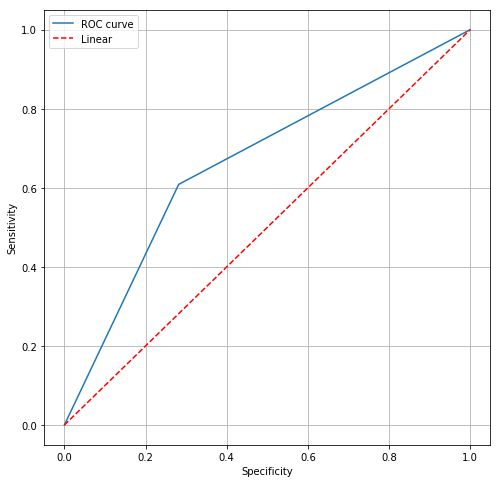

In [23]:
plt.figure(figsize=(8,8))
plt.plot(ROCn[0], ROCn[1], label = "ROC curve")
plt.plot([0,1],[0,1], "r--", label = 'Linear')
plt.grid()
plt.legend(loc = "best")
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
print(f"AUC: {AUC}")

# 4)

There are two methods. The first is for just random (probably overlaying folds), the second is my own -not that optimized nor sexy- piece of code to make sure there is no overlay.

---

For the first (totally random) method:

In [29]:
rocs, aucs = [], []
for i in range(5):
    train, test = train_test_split(dfn, test_size=0.2, random_state = i+1)
    model = LogisticRegression(fit_intercept=False, C=9e9).fit(train.drop("huric", axis = 1),train.huric )
    wn = model.predict(test.drop("huric", axis = 1))
    rocs.append(roc_curve(test.huric, wn))
    aucs.append(roc_auc_score(test.huric, wn))

AUC: 0.8805147058823529 for the 1. try
AUC: 0.8759398496240602 for the 2. try
AUC: 0.8327067669172933 for the 3. try
AUC: 0.7954545454545453 for the 4. try
AUC: 0.8888888888888888 for the 5. try


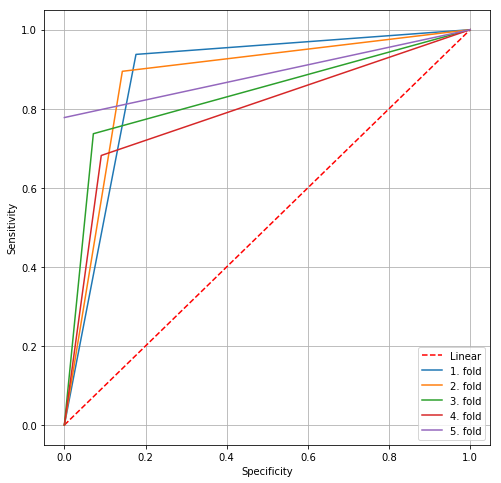

In [33]:
plt.figure(figsize=(8,8))
cnt = 0
plt.plot([0,1],[0,1], "r--", label = 'Linear')
for roc, auc in zip(rocs, aucs):
    cnt +=1
    plt.plot(roc[0], roc[1], label = f"{cnt}. fold")
    plt.legend(loc = "best")
    plt.grid()
    plt.ylabel('Sensitivity')
    plt.xlabel('Specificity')
    print(f"AUC: {auc} for the {cnt}. try")

Notes: 

- Since the excercise says that there is a $\textit{seed}$, I suppose a randomness, so I cannot assure that the folds do not overlay.
- I will try it with my own method

---

My own method (no overlay):

In [46]:
dr = dfn.sample(random_state=0, frac=1)

In [48]:
dr.head()

,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,Radius,Metacarpal,LongestFinger,FingerCount,ToeCount,MeanFingerArea,MeanToeArea,orig,sex,huric
161,-0.609204,-0.652368,-1.165549,-0.940164,-0.696114,-0.682807,-0.582303,-0.992255,-0.684386,-0.598691,-0.750187,-0.798451,-0.905173,0.954996,-1.120774,0.0
150,0.819107,0.926224,0.575836,0.450332,1.437639,0.087294,0.770544,0.887233,0.488466,1.225359,0.787932,1.035017,0.938627,0.954996,0.886766,0.0
74,1.072285,0.926224,0.731424,0.984363,0.606797,0.526323,0.826913,1.369805,1.007871,-0.598691,0.018873,1.290934,1.133536,0.954996,0.886766,1.0
7,1.185340,0.545979,0.527963,0.702233,0.701211,0.943760,0.883281,0.988827,0.639261,0.313334,-1.519247,1.806426,1.633132,-1.040701,0.886766,1.0
101,0.626436,0.776430,0.557884,0.873526,1.409315,0.216843,0.864492,1.217414,1.192177,0.313334,1.556992,0.734008,0.826610,-1.040701,0.886766,0.0


In [52]:
cut = dr.shape[0] // 5

In [53]:
dfs = []
dfn["huric"] = dr.huric
for i in range(5):
    if i !=4:
        dfs.append(dr.iloc[ i*cut:(i+1)*cut, :])
    else:
        dfs.append(dr.iloc[i*cut:, :])


In [54]:
rocs, aucs = [], []

for i, df in enumerate(dfs):
    alldf = dfs.copy()
    del alldf[i]
    dftotal = pd.concat(alldf)
    model = LogisticRegression(fit_intercept=False, C=9e9).fit(dftotal.drop("huric", axis = 1),dftotal.huric )
    wn = model.predict(df.drop("huric", axis = 1))
    rocs.append(roc_curve(df.huric, wn))
    try:
        aucs.append(roc_auc_score(df.huric, wn))
    except ValueError:
        print('valuerr')
        aucs.append(0)

In [28]:
dftotal

,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,Radius,Metacarpal,LongestFinger,FingerCount,ToeCount,MeanFingerArea,MeanToeArea,orig,sex,huric
0,-0.139470,-0.306691,-0.094388,-0.023243,0.144169,-0.243778,0.131700,-1.449428,-1.052997,-1.510716,-1.519247,-0.434683,-0.097904,-1.040701,0.886766,1.0
1,-1.473833,-1.303394,-1.339089,-1.373435,-1.017121,-0.711596,-1.258726,-1.043052,-0.449816,-1.510716,-0.750187,-1.113474,-1.123606,-1.040701,-1.120774,1.0
2,1.390749,1.122108,1.635029,1.921437,2.174066,1.958566,1.587889,1.903173,2.130458,2.137384,0.787932,1.939259,1.766433,-1.040701,0.886766,1.0
3,-1.021614,-1.366768,-1.039882,-0.950241,-0.960472,-1.129033,-1.174173,-0.001714,-0.449816,-0.598691,-1.519247,-0.718020,-0.719225,-1.040701,-1.120774,1.0
4,-0.645827,-0.381588,-0.603040,-0.658035,-0.242927,-0.927512,-0.563513,-0.687473,-0.751406,-0.598691,-0.750187,-0.340237,0.010753,-1.040701,-1.120774,1.0
5,-0.413348,-0.519859,-0.746659,-0.698339,-0.091865,-0.394919,-0.657461,-1.017654,-0.935712,0.313334,0.018873,-0.264071,-0.542985,-1.040701,-1.120774,1.0
6,0.527712,1.047211,0.240724,0.359647,0.899480,0.634281,0.516885,0.912632,0.806811,-0.598691,0.018873,0.525009,0.508855,-1.040701,0.886766,1.0
7,1.185340,0.545979,0.527963,0.702233,0.701211,0.943760,0.883281,0.988827,0.639261,0.313334,-1.519247,1.806426,1.633132,-1.040701,0.886766,1.0
8,-1.018430,-0.537143,-0.537214,-0.668111,-0.545052,-0.877131,-0.695040,0.074481,-0.768161,0.313334,-0.750187,-0.900209,-0.839083,-1.040701,-1.120774,1.0
9,0.737898,0.229108,0.623709,0.228659,0.399087,0.857394,0.798728,0.658647,0.505221,0.313334,1.556992,1.332369,1.548373,-1.040701,0.886766,1.0


---

AUC: 0.75 for the 1. fold
AUC: 0.815686274509804 for the 2. fold
AUC: 0.8825910931174089 for the 3. fold
AUC: 0.7793522267206477 for the 4. fold
AUC: 0.9642857142857143 for the 5. fold


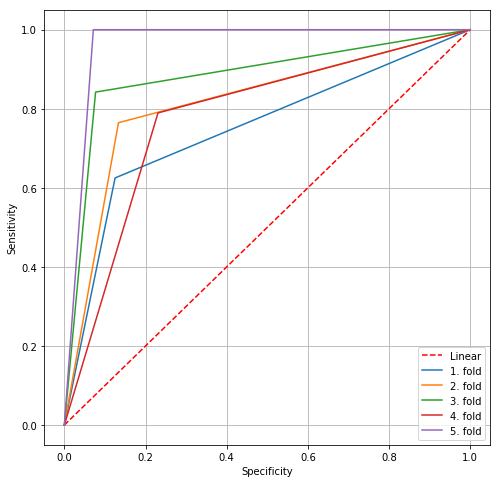

In [56]:
plt.figure(figsize=(8,8))
cnt = 0
plt.plot([0,1],[0,1], "r--", label = 'Linear')
for roc, auc in zip(rocs, aucs):
    cnt +=1
    plt.plot(roc[0], roc[1], label = f"{cnt}. fold")
    plt.legend(loc = "best")
    plt.grid()
    plt.ylabel('Sensitivity')
    plt.xlabel('Specificity')
    print(f"AUC: {auc} for the {cnt}. fold")

Notes:

- Randomizing the rows is necessary for the ROC and AUC calculation
- These do seem to show a tendency: the last fold (more rows) has a higher sensitivity at the same low specificity.